In [3]:
import pandas as pd
import os 
from sklearn.metrics import f1_score as f1 
import matplotlib.pyplot as plt
import numpy as np
os.chdir(os.path.dirname(os.getcwd()))
os.getcwd()

'c:\\Users\\Auguste\\Desktop\\ADNe\\TeleoClassification\\scripts'

In [6]:
# Change the paths to the data files here

data_path_teleo_clean = r"C:\Users\Auguste Verdier\Desktop\TeleoClassification\data\teleo_clean"

OBI_pred_path = r'C:\Users\Auguste\Desktop\ADNe\Obitools_preds'
BERT_DNABERT_pred_path = "./BERT_DNABERT_preds/"

Barcode = r"C:\Users\Auguste Verdier\Desktop\TeleoClassification\scripts\BERTeleo\experiments\barcodebert\outputs\6_fold_single_barcodebert_teleo_clean\checkpoints"

In [20]:
def f1_score(y_true, y_pred,conf,null_pred='NC',thresholds=np.arange(0, 1, 0.001)):
    

    classes = np.unique(np.concatenate((y_true, y_pred[y_pred != null_pred])))

    f1_scores = []
    
    for threshold in thresholds:
        y_pred_thresholded = np.where(conf >= threshold, y_pred, null_pred)
        TP = {cls: 0 for cls in classes}
        FP = {cls: 0 for cls in classes}
        FN = {cls: 0 for cls in classes}

        for true_label, pred_label in zip(y_true, y_pred_thresholded):
            if pred_label == null_pred:
                FN[true_label] += 1
            else:
                if true_label == pred_label:
                    TP[true_label] += 1
                else:
                    FP[pred_label] += 1
                    FN[true_label] += 1

        precision = [TP[cls] / (TP[cls] + FP[cls]) if TP[cls] + FP[cls]> 0 else 0 for cls in classes]
        recall = [TP[cls] / (TP[cls] + FN[cls]) if TP[cls] + FN[cls] > 0 else 0 for cls in classes]
        f1_score = [2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls]) if precision[cls] + recall[cls] > 0 else 0 for cls in range(len(precision))]
        macro_f1 = np.mean(f1_score)
        f1_scores.append(macro_f1)
    return thresholds,f1_scores

## Obitools

### Macro Accuracy

In [4]:
import numpy as np

In [5]:
acc = []
f1_scrores = []
p_score =[]
r_score =[]
for fold in range(1,7):

    preds = pd.read_csv(OBI_pred_path +f'/fold_{fold}/test_ecotag_pred.csv')
    # labels = pd .read_csv(data_path_teleo_clean+ f'/fold_{fold}/test.csv')

    preds['preds'] = preds['pred_family'].apply(lambda x: x.split('.')[0])

    classes =np.concatenate([preds['ak_family'].unique() , preds['preds'].unique()]) 

    # print(classes[classes=='NC'])
    classes = classes[classes!='NC']
    # print(classes)
    per_class_accuracy = preds.groupby('ak_family').apply(lambda group: (group['preds'] == group['ak_family']).mean(), include_groups=True)

    macro_avg_accuracy = per_class_accuracy.mean()
    acc.append(macro_avg_accuracy)
    print(f'Fold {fold} macro avg accuracy: {macro_avg_accuracy}')
    # p,r,f,s=prfs(preds['ak_family'], preds['preds'], average='macro', labels=classes)
    print(f'Fold {fold} macro avg f1: {f1(preds["ak_family"], preds["preds"], average="macro")}')
    f1_scrores.append(f1(preds["ak_family"], preds["preds"], average="macro"))


print('Mean Macro Accuracy',sum(acc)/len(acc))
print('Mean Macro F1',sum(f1_scrores)/len(f1_scrores))



Fold 1 macro avg accuracy: 0.4449987579248107
Fold 1 macro avg f1: 0.44831247571658006
Fold 2 macro avg accuracy: 0.41722979363758894
Fold 2 macro avg f1: 0.4163432115988858
Fold 3 macro avg accuracy: 0.40000878077705726
Fold 3 macro avg f1: 0.41289766125400107
Fold 4 macro avg accuracy: 0.40476562588305387
Fold 4 macro avg f1: 0.4110738113169477
Fold 5 macro avg accuracy: 0.42018922624031063
Fold 5 macro avg f1: 0.42375990444758227
Fold 6 macro avg accuracy: 0.42571860541847234
Fold 6 macro avg f1: 0.4235814838132357
Mean Macro Accuracy 0.41881846498021563
Mean Macro F1 0.42266142469120543


C:\Users\Auguste\AppData\Local\Temp\ipykernel_24768\1500799366.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_accuracy = preds.groupby('ak_family').apply(lambda group: (group['preds'] == group['ak_family']).mean(), include_groups=True)
C:\Users\Auguste\AppData\Local\Temp\ipykernel_24768\1500799366.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_accuracy = preds.groupby('ak_fam

### Macro F1

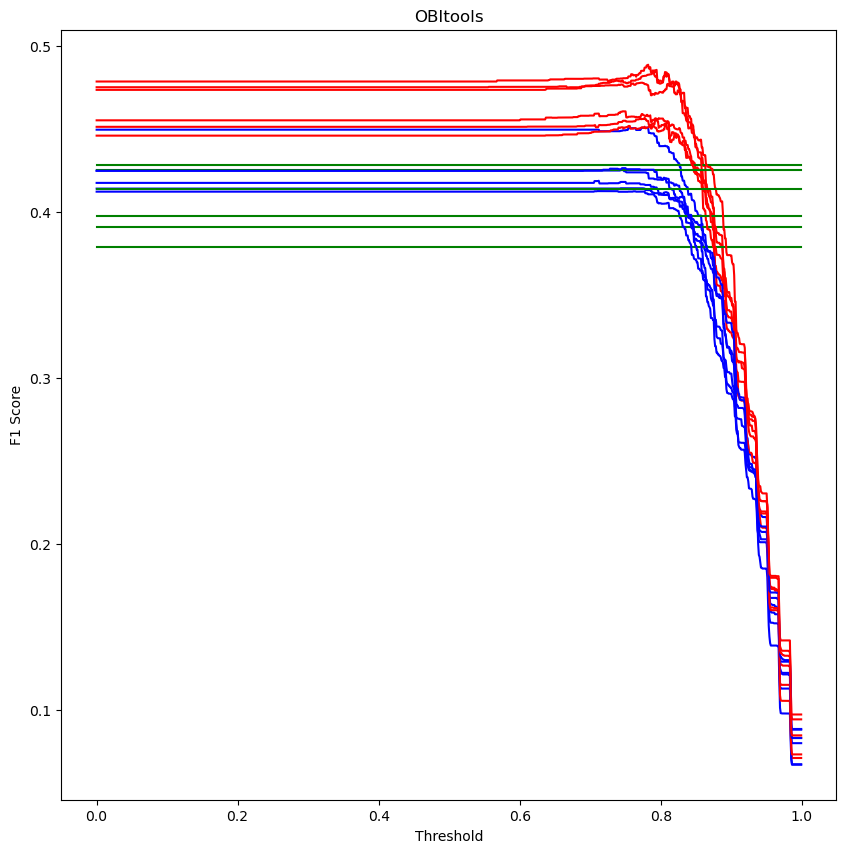

In [25]:


fig = plt.figure(figsize=(10, 10))

for fold in range(1,7):

    preds = pd.read_csv(OBI_pred_path +f'/fold_{fold}/test_ecotag_pred.csv')
    # labels = pd .read_csv(data_path_teleo_clean+ f'/fold_{fold}/test.csv')

    x,y = f1_score(preds['ak_family'], preds['pred_family'],preds['best_identity:train'])
    plt.plot(x,y,label=f'Fold {fold}',c = 'b')
    x,y = f1_score(preds['ak_family'], preds['best_match:train'].apply(lambda x: x.split('.')[0]),preds['best_identity:train'])
    plt.plot(x,y,label=f'Fold {fold}',c = 'r')

    data = pd.read_csv(rf'C:\Users\Auguste\Desktop\ADNe\TeleoClassification\Bert_DNABERT2_single_taxa\predictions_fold_{fold}.csv')

    conf = np.ones(len(data['labels_family']))
    preds = data['preds_family'].astype(str)
    labels = data['labels_family'].astype(str)

    x,y = f1_score(labels, preds,conf)
    plt.plot(x,y,label=f'Fold {fold}',c = 'g')

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
# plt.legend()
plt.title('OBItools')
plt.show()


## DNABERT_2

In [10]:
padnas_macro= []
F = []
for fold in range(1,7):
    preds = pd.read_csv(rf'C:\Users\Auguste\Desktop\ADNe\TeleoClassification\Bert_DNABERT2_single_taxa\predictions_fold_{fold}.csv')
    

    per_class_accuracy = preds.groupby('labels_family').apply(lambda group: (group['preds_family'] == group['labels_family']).mean())

    macro_avg_accuracy = per_class_accuracy.mean()
    padnas_macro.append(macro_avg_accuracy)
    # print("acc",macro_avg_accuracy)
    
    F1 = f1(preds['labels_family'],preds['preds_family'],average='macro')
    F.append(F1)
    print('f1',F1 , 'acc',macro_avg_accuracy)
    

print(sum(padnas_macro)/len(padnas_macro))
print(sum(F)/len(F))

f1 0.3911163499906016 acc 0.4930422025105215
f1 0.3788507567327369 acc 0.47491686102619496
f1 0.4282510340927133 acc 0.5272942109052676
f1 0.39766869314710274 acc 0.5046770741800306
f1 0.4252714052868902 acc 0.5254382238432753
f1 0.4142182379033826 acc 0.524567281271879
0.5083226422895282
0.4058960795255712


C:\Users\Auguste\AppData\Local\Temp\ipykernel_19200\4018361350.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_accuracy = preds.groupby('labels_family').apply(lambda group: (group['preds_family'] == group['labels_family']).mean())
C:\Users\Auguste\AppData\Local\Temp\ipykernel_19200\4018361350.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_accuracy = preds.groupby('labels_family'

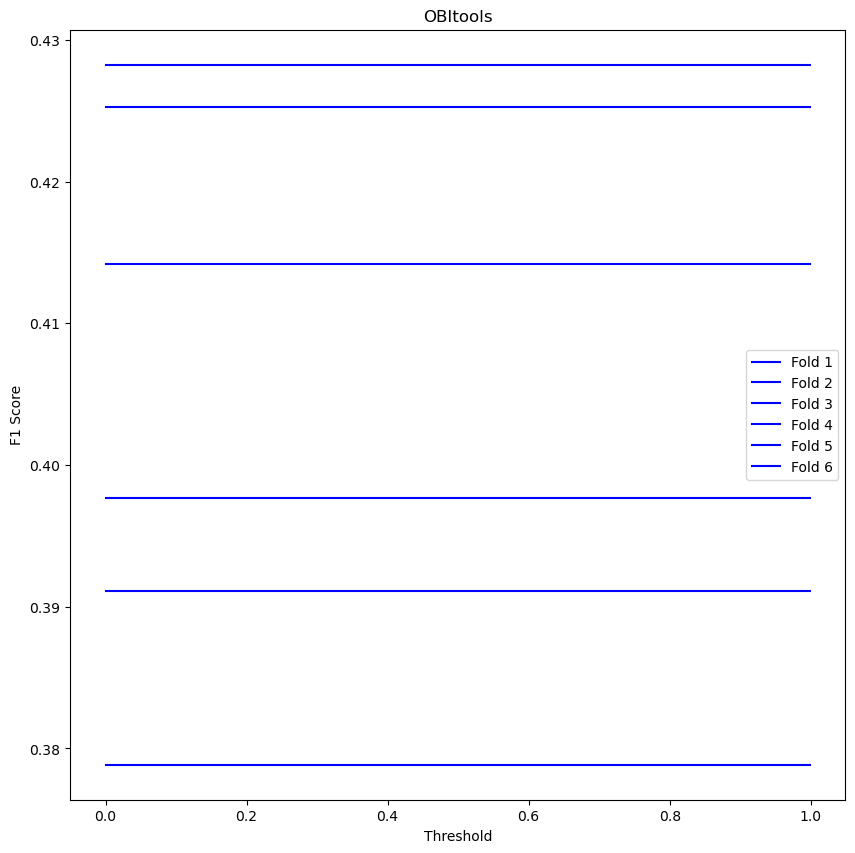

In [22]:
fig = plt.figure(figsize=(10, 10))

for fold in range(1,7):

    



plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.title('OBItools')
plt.show()

## Barcode Bert

In [21]:
padnas_macro= []
F = []
for fold in range(1,7):
    preds = pd.read_csv(Barcode +f'/fold_{fold}/predictions.csv')
    

    per_class_accuracy = preds.groupby('labels_family').apply(lambda group: (group['preds_family'] == group['labels_family']).mean())

    macro_avg_accuracy = per_class_accuracy.mean()
    padnas_macro.append(macro_avg_accuracy)
    # print("acc",macro_avg_accuracy)
    
    F1 = f1(preds['labels_family'],preds['preds_family'],average='macro')
    F.append(F1)
    print('f1',F1)
    

print(sum(padnas_macro)/len(padnas_macro))
print(sum(F)/len(F))

f1 0.39516462966459004
f1 0.36625957317656693
f1 0.377464104154733
f1 0.3666384742519485
f1 0.38714480356796305
f1 0.3671008373658139
0.4665312928602198
0.3766287370302692


C:\Users\Auguste Verdier\AppData\Local\Temp\ipykernel_4600\1601434867.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_accuracy = preds.groupby('labels_family').apply(lambda group: (group['preds_family'] == group['labels_family']).mean())
C:\Users\Auguste Verdier\AppData\Local\Temp\ipykernel_4600\1601434867.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_accuracy = preds.groupby('